In [57]:
import keras
import tensorflow as tf
import keras_retinanet
from keras_retinanet.utils.image import preprocess_image
from keras_retinanet.utils.image import read_image_bgr
from keras_retinanet.utils.image import resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet import models
from imutils import paths
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image  
import PIL  
import matplotlib.image as mpimg
from matplotlib.backends.backend_pdf import PdfPages
import os
import argparse

%matplotlib inline

In [2]:
import os

In [35]:
basedir = '/home/user1/rohit/UAVDT'
train_images_dir = os.path.join(basedir, 'UAV-benchmark-M')
train_annotation_dir = os.path.join(basedir, 'UAV-benchmark-MOTD_v1.0/GT')
relative_images_dir = './UAV-benchmark-M'
class_mapping = './class-mapping.csv'
train_annotations = './sorted_train_ann.csv'

In [6]:
%pwd

'/home/user1/rohit/UAVDT'

In [7]:
%ls

change-annotations.ipynb  retinanet-uavdt.ipynb     UAV-benchmark-S/
class-mapping.csv         sorted_ann.csv            UAV-benchmark-SOT_v1.0/
converted_ann.csv         UAV-benchmark-M/          UAV-benchmark-S.zip*
M_attr/                   UAV-benchmark-MOTD_v1.0/
pyunzip.py*               UAV-benchmark-M.zip*


In [8]:
sequences = sorted(os.listdir(train_images_dir))
print(sequences)

['M0101', 'M0201', 'M0202', 'M0203', 'M0204', 'M0205', 'M0206', 'M0207', 'M0208', 'M0209', 'M0210', 'M0301', 'M0401', 'M0402', 'M0403', 'M0501', 'M0601', 'M0602', 'M0603', 'M0604', 'M0605', 'M0606', 'M0701', 'M0702', 'M0703', 'M0704', 'M0801', 'M0802', 'M0901', 'M0902', 'M1001', 'M1002', 'M1003', 'M1004', 'M1005', 'M1006', 'M1007', 'M1008', 'M1009', 'M1101', 'M1102', 'M1201', 'M1202', 'M1301', 'M1302', 'M1303', 'M1304', 'M1305', 'M1306', 'M1401']


In [41]:
test_seq = ['M0203','M0205','M0208','M0209','M0403','M0601','M0602','M0606','M0701','M0801','M0802','M1001','M1004','M1007','M1009','M1101','M1301','M1302','M1303','M1401']
print(f'Number of test sequences : {len(test_seq)}')

Number of test sequences : 20


In [42]:
train_seq = list(set(sequences) - set(test_seq))
print(f'Number of train sequences : {len(train_seq)}')

Number of train sequences : 30


In [47]:
num_train_imgs = 0
for seq in train_seq:
    num_train_imgs += len(os.listdir(os.path.join(relative_images_dir, seq)))
print(f'Number of train images : {num_train_imgs}')

Number of train images : 24143


In [48]:
num_test_imgs = 0
for seq in test_seq:
    num_test_imgs += len(os.listdir(os.path.join(relative_images_dir, seq)))
print(f'Number of train images : {num_test_imgs}')

Number of train images : 16592


In [49]:
LABELS = open(class_mapping).read().strip().split('\n')
LABELS = {L.split(",")[0]: int(L.split(",")[1]) for L in LABELS}
print(LABELS)

{'car': 0, 'truck': 1, 'bus': 2}


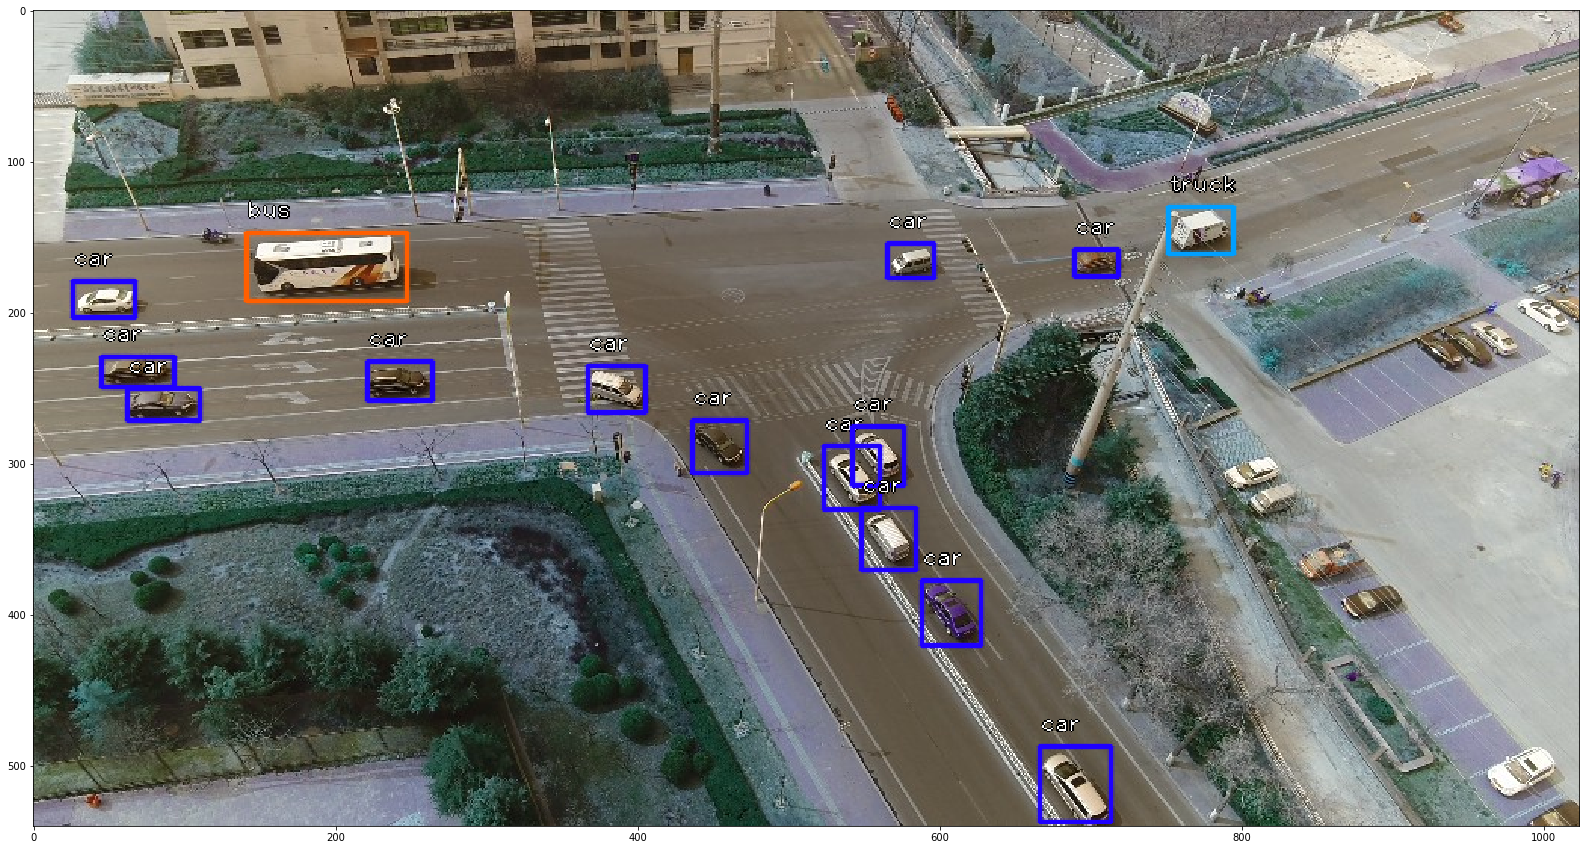

In [38]:
plt.figure(figsize=(30,15))
ann = open(train_annotations, "r")
lines = ann.readlines()
for i in range(len(lines)):
    box=lines[i].strip().split(',')
    img = cv2.imread(box[0])
    while(lines[i].strip().split(',')[0] == box[0]):
        next_box = lines[i].strip().split(',')
        draw_box(img, next_box[1:5], label_color(LABELS[next_box[-1]]))
        draw_caption(img, np.array(next_box[1:5], dtype='int32'), next_box[-1])
        i+=1
    plt.imshow(img)
    break
    
#print("done")
ann.close()

In [55]:
model = keras_retinanet.models.backbone('resnet50').retinanet(num_classes=3)
print(model.summary())

Model: "retinanet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________

In [58]:
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal()
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
)